In [1]:
import pandas as pd
import requests
import numpy as np
import tweepy
import statsmodels.api as sm
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import os
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Gathering relevant data

In [2]:
# import .csv-file with WeRateDogs basic information
df_dogs = pd.read_csv('./twitter-archive-enhanced.csv')

In [3]:
# import .tsv-file with predicted dog breed
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('./image-predictions.tsv', mode = 'wb') as file:
        file.write(response.content)
        
df_predictions = pd.read_csv('./image-predictions.tsv', sep='\t')

In [4]:
# import dog relevance data from Twitter API

## Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
## These are hidden to comply with Twitter's API terms and conditions
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

## NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
## df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
## change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
## NOTE TO REVIEWER: this student had mobile verification issues so the following
## Twitter API code was sent to this student from a Udacity instructor
## Tweet IDs for which to gather additional data via Twitter's API
#tweet_ids = df_dogs.tweet_id.values
#len(tweet_ids)

## Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
## Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
#    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [5]:
# save information in a .txt-file
# filter for relevant data
relevant = ['id', 'favorite_count', 'retweet_count']
data = []

with open('tweet-json.txt', 'r') as readfile: 
    # impot json as dict
    tweet_json = readfile.readline()
    
    # read relevant data line by line
    while tweet_json:
        tweet_dict = json.loads(tweet_json)
        data_row = dict((k, tweet_dict[k]) for k in relevant)
        data.append(data_row)
        tweet_json = readfile.readline()
          
df_twitter_results = pd.DataFrame.from_dict(data)
#df_twitter_results.head()

## Assessing data

#### df_dogs

In [6]:
# print first rows for initial visual assessment
df_dogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [7]:
# show data types and missing values
df_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
# show number of duplicates
sum(df_dogs.duplicated())

0

In [9]:
# show statistical characteristics
df_dogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# list all unique entries
df_dogs.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [11]:
# list all unique entries
df_dogs.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
# list all unique entries
df_dogs.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Oliver       11
Lucy         11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
an            7
Toby          7
Daisy         7
Buddy         7
Bailey        7
Scout         6
Milo          6
Oscar         6
Rusty         6
Stanley       6
Jack          6
Bella         6
Koda          6
Jax           6
Leo           6
Dave          6
Finn          5
           ... 
Joshwa        1
Oddie         1
Holly         1
Olaf          1
Karl          1
Siba          1
Adele         1
Alfy          1
Julio         1
Berb          1
Cupid         1
Champ         1
Rodney        1
Kuyu          1
Bauer         1
Todo          1
Beemo         1
Jordy         1
Clarkus       1
Zoe           1
Norman        1
Monster       1
Nimbus        1
Linus         1
Flurpson      1
Craig         1
Steve         1
Kody          1
Staniel       1
Harry         1
Name: name, Length: 957,

In [13]:
# show number of entries without any status entry
df_dogs[(df_dogs.doggo != "None") | (df_dogs.floofer != "None") | (df_dogs.pupper != "None") | (df_dogs.puppo != "None")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,None,None,None,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
71,878776093423087618,NaN,NaN,2017-06-25 00:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Snoopy. He's a proud #PrideMonthPuppo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878776093...,13,10,Snoopy,None,None,None,puppo
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None


#### df_predictions

In [14]:
# print first rows for initial visual assessment
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
# show data types and missing values
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
# show number of duplicates
sum(df_predictions.duplicated())

0

In [17]:
# show statistical characteristics
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
# list all unique entries
df_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

#### df_twitter_results

In [19]:
# print first rows for initial visual assessment
df_twitter_results.head()

,favorite_count,id,retweet_count
0,39467,892420643555336193,8853
1,33819,892177421306343426,6514
2,25461,891815181378084864,4328
3,42908,891689557279858688,8964
4,41048,891327558926688256,9774


In [20]:
# show data types and missing values
df_twitter_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
id                2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [21]:
# show number of duplicates
sum(df_twitter_results.duplicated())

0

In [22]:
# show statistical characteristics
df_twitter_results.describe()

,favorite_count,id,retweet_count
count,2354.000000,2.354000e+03,2354.000000
mean,8080.968564,7.426978e+17,3164.797366
std,11814.771334,6.852812e+16,5284.770364
min,0.000000,6.660209e+17,0.000000
25%,1415.000000,6.783975e+17,624.500000
50%,3603.500000,7.194596e+17,1473.500000
75%,10122.250000,7.993058e+17,3652.000000
max,132810.000000,8.924206e+17,79515.000000


In [23]:
# count number of 0 in favorite_count
df_twitter_results[(df_twitter_results.favorite_count == 0)].count()

favorite_count    179
id                179
retweet_count     179
dtype: int64

###### Quality Issues
* df_dogs
    * sorce includes html-code
    * timestamp is not a datetime64 type
    * retweeted_status_timestamp is not a datetime64 type
    * inconsistent capitalization in name
    * dog names "a", "the", "an" don't seem to be plausible (entry error?)
    * rating denominator with value "0" (singularity)
    * overall rating is missing
* df_predictions
    * p1 to p3 are not categorical (will be dropped anyway)
    * missing data (2075 instaed of 2356 / will be adressed with "Inner-Join")
    * inconsistent capitalization in breed categories
* df_twitter_results
    * missing data (2354 instaed of 2356 / will be adressed with "Inner-Join")

###### Tidiness Issues
* df_dogs
    * dog "stage" is one variable and should be listed in a single column
* df_predictions
    * there are multiple columns representing the dogs potential breed
* df_twitter_results
* general
    * all tables refer to one observation and should be combined in one table
    * there are many zeros in favorite_count

## Cleaning data

In [24]:
# create copies of dataframes
df_dogs_copy = df_dogs.copy()
df_predictions_copy = df_predictions.copy()
df_twitter_results_copy = df_twitter_results.copy()

#### Missing Values

In [25]:
## DEFINE
# drop rows in df_dogs that have no counterpart (tweet_id) in df_predictions
# This became redundant after final INNER-JOIN
## CODE
# df_dogs_copy = df_dogs_copy[df_dogs_copy.tweet_id.isin(df_predictions_copy.tweet_id)]
## TEST
# df_dogs_copy.info()

In [26]:
## DEFINE
# drop rows in df_dogs that have no counterpart (tweet_id) in df_twitter_results
# This became redundant after final INNER-JOIN
## CODE
# df_dogs_copy = df_dogs_copy[df_dogs_copy.tweet_id.isin(df_twitter_results_copy.id)]
## TEST
# df_dogs_copy.info()

In [27]:
## DEFINE
# drop rows in df_predictions that have no counterpart (tweet_id) in df_dogs
# This became redundant after final INNER-JOIN
## CODE
# df_predictions_copy = df_predictions_copy[df_predictions_copy.tweet_id.isin(df_dogs_copy.tweet_id)]
## TEST
# df_predictions_copy.info()

In [28]:
## DEFINE
# drop rows in df_twitter_results that have no counterpart (tweet_id) in df_dogs
# This became redundant after final INNER-JOIN
## CODE
# df_twitter_results_copy = df_twitter_results_copy[df_twitter_results_copy.id.isin(df_dogs_copy.tweet_id)]
## TEST
# df_twitter_results_copy.info()

In [29]:
# This became redundant after final INNER-JOIN
#(len(df_dogs_copy) == len(df_predictions_copy) == len(df_twitter_results_copy))

#### Tidiness

In [30]:
## DEFINE
# dog "state" needs to become a single variable
## CODE
def dogstatus(pdrow):
    if pdrow['doggo'] == "doggo":
        return "doggo"
    elif pdrow['floofer'] == "floofer":
        return "floofer"
    elif pdrow['pupper'] == "pupper":
        return "pupper"
    elif pdrow['puppo'] == "puppo":
        return "puppo"
    else:
        return np.nan
        
df_dogs_copy['dog_status'] = df_dogs_copy.apply(dogstatus, axis = 1)
df_dogs_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace = True)
## TEST
df_dogs_copy[~(df_dogs_copy.dog_status.isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_status
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,pupper
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,floofer
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,pupper
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,pupper
71,878776093423087618,NaN,NaN,2017-06-25 00:45:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Snoopy. He's a proud #PrideMonthPuppo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878776093...,13,10,Snoopy,puppo
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,pupper


In [31]:
## DEFINE
# identify the most probable dog breet
## CODE
def dogbreed(pdrow):
    if pdrow.p1_dog == True:
        return pdrow.p1
    elif pdrow.p2_dog == True:
        return pdrow.p2
    elif pdrow.p3_dog == True:
        return pdrow.p3
    else:
        return np.nan
        
df_predictions_copy['dog_breed'] = df_predictions_copy.apply(dogbreed, axis = 1)
df_predictions_copy.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace = True)
## TEST
#df_predictions_copy.head()
len(df_predictions_copy.dog_breed[df_predictions_copy.dog_breed.isnull()])

324

In [32]:
## DEFINE
# Use INNER-JOIN to merge all tables since it represents a single observation
## CODE
df = df_dogs_copy.merge(df_predictions_copy, left_on='tweet_id', right_on='tweet_id', how='inner')
df = df.merge(df_twitter_results_copy, left_on='tweet_id', right_on='id', how='inner')
df.drop(['id'], axis=1, inplace = True)
## TEST
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 19 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
dog_status                    320 non-null object
jpg_url                       2073 non-null object
img_num                       2073 non-null int64
dog_breed                     1750 non-null object
favorite_count                2073 no

#### Quality

In [33]:
## DEFINE
# use exclusively lowercase capitalization with dog breeds
## CODE
df.dog_breed = df.dog_breed.str.lower()
## TEST
df.dog_breed.value_counts()

golden_retriever                  173
labrador_retriever                113
pembroke                           95
chihuahua                          95
pug                                65
toy_poodle                         52
chow                               51
samoyed                            46
pomeranian                         42
cocker_spaniel                     34
malamute                           34
french_bulldog                     32
chesapeake_bay_retriever           31
miniature_pinscher                 26
cardigan                           23
eskimo_dog                         22
staffordshire_bullterrier          22
german_shepherd                    21
beagle                             21
shih-tzu                           20
siberian_husky                     20
lakeland_terrier                   19
kuvasz                             19
shetland_sheepdog                  19
maltese_dog                        19
rottweiler                         19
basset      

In [34]:
## DEFINE
# use exclusively title capitalization with name
## CODE
df.name = df.name.str.title()
## TEST
df.name.value_counts()

None        577
A            55
Charlie      11
Lucy         10
Cooper       10
Oliver       10
Tucker       10
Penny        10
Bo            8
Sadie         8
Winston       8
Lola          8
Daisy         7
An            7
Toby          7
The           7
Rusty         6
Dave          6
Scout         6
Jax           6
Bailey        6
Stanley       6
Bella         6
Koda          6
Milo          6
Alfie         5
Louis         5
Oscar         5
Buddy         5
Chester       5
           ... 
Terrenth      1
Tuck          1
Napolean      1
Joshwa        1
Jamesy        1
Striker       1
Eevee         1
Adele         1
Julio         1
Cupid         1
Champ         1
Rodney        1
Kuyu          1
Bauer         1
Koko          1
Todo          1
Beemo         1
Jordy         1
Kyro          1
Zoe           1
Clarkus       1
Norman        1
Rinna         1
Nimbus        1
Flurpson      1
Craig         1
Steve         1
Kody          1
Staniel       1
Harry         1
Name: name, Length: 936,

In [35]:
## DEFINE
# change dog names "A", "An", "The" to "None"
## CODE
df.name = df.name.replace('A', 'None')
df.name = df.name.replace('An', 'None')
df.name = df.name.replace('The', 'None')
## TEST
df.name.value_counts()

None        646
Charlie      11
Oliver       10
Tucker       10
Cooper       10
Lucy         10
Penny        10
Winston       8
Bo            8
Sadie         8
Lola          8
Toby          7
Daisy         7
Bella         6
Rusty         6
Scout         6
Koda          6
Stanley       6
Bailey        6
Dave          6
Jax           6
Milo          6
Leo           5
Oscar         5
Buddy         5
Alfie         5
Chester       5
Larry         5
Louis         5
Scooter       4
           ... 
Terrenth      1
Tuck          1
Napolean      1
Joshwa        1
Jamesy        1
Eevee         1
Adele         1
Zoe           1
Jordy         1
Berb          1
Cupid         1
Champ         1
Rodney        1
Kuyu          1
Bauer         1
Koko          1
Todo          1
Beemo         1
Julio         1
Staniel       1
Kyro          1
Clarkus       1
Norman        1
Rinna         1
Nimbus        1
Flurpson      1
Craig         1
Steve         1
Kody          1
Harry         1
Name: name, Length: 933,

In [36]:
## DEFINE
# convert all timestamp to date type
## CODE
df.timestamp = pd.to_datetime(df.timestamp)
## TEST
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 19 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null datetime64[ns]
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
dog_status                    320 non-null object
jpg_url                       2073 non-null object
img_num                       2073 non-null int64
dog_breed                     1750 non-null object
favorite_count               

In [37]:
# identify observation time span
print(df.timestamp.min())
print(df.timestamp.max())

2015-11-15 22:32:08
2017-08-01 16:23:56


In [38]:
## DEFINE
# convert all retweeted_status_timestamp to date type
## CODE
df.retweeted_status_timestamp = pd.to_datetime(df.retweeted_status_timestamp)
## TEST
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 19 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null datetime64[ns]
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null datetime64[ns]
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
dog_status                    320 non-null object
jpg_url                       2073 non-null object
img_num                       2073 non-null int64
dog_breed                     1750 non-null object
favorite_count       

In [39]:
## DEFINE
# clear "source" from html relics
## CODE
def getCleanSourceHtml(pdentry):
    return BeautifulSoup(pdentry, "lxml").find('a', href=True)['href']
        
df.source = df.source.apply(getCleanSourceHtml)
## TEST
df.source.value_counts()

http://twitter.com/download/iphone              2032
http://twitter.com                                30
https://about.twitter.com/products/tweetdeck      11
Name: source, dtype: int64

In [40]:
## DEFINE
# change rating_denominator with value "0" to "10"
## CODE
df.rating_denominator = df.rating_denominator.replace(0, 10)
## TEST
df.rating_denominator.value_counts()

10     2055
50        3
11        2
80        2
7         1
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [41]:
## DEFINE
# calculate overall rating
## CODE
df['rating'] = df.rating_numerator / df.rating_denominator
## TEST
df.rating.value_counts()

1.200000      477
1.000000      431
1.100000      419
1.300000      283
0.900000      151
0.800000       95
0.700000       51
1.400000       40
0.500000       35
0.600000       32
0.300000       19
0.400000       15
0.200000       10
0.100000        4
0.000000        2
0.818182        1
2.700000        1
3.428571        1
0.636364        1
177.600000      1
2.600000        1
42.000000       1
7.500000        1
1.500000        1
Name: rating, dtype: int64

In [42]:
# show final cleansed dataframe
df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_status,jpg_url,img_num,dog_breed,favorite_count,retweet_count,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,NaN,39467,8853,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,33819,6514,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,25461,4328,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,labrador_retriever,42908,8964,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,41048,9774,1.2
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,http://twitter.com/download/iphone,Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake_bay_retriever,20562,3261,1.3
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,http://twitter.com/download/iphone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,appenzeller,12041,2158,1.3
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,http://twitter.com/download/iphone,When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,pomeranian,56848,16716,1.3
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,http://twitter.com/download/iphone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,irish_terrier,28226,4429,1.3
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,http://twitter.com/download/iphone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,pembroke,32467,7711,1.4


## Data storing

In [43]:
# delete existing db first
os.remove('./twitter_archive_master.db')
# Create SQLAlchemy Engine and empty doggy database
# doggy.db will not show up in the Jupyter Notebook dashboard yet
engine = create_engine('sqlite:///twitter_archive_master.db')
# Store cleaned master DataFrame ('df') in a table called master
if not engine.dialect.has_table(engine, 'master'):
    df.to_sql('master', engine, index = False)
    
df = pd.read_sql('SELECT * FROM master', engine)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_status,jpg_url,img_num,dog_breed,favorite_count,retweet_count,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56.000000,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,None,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,None,39467,8853,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27.000000,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,None,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,33819,6514,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03.000000,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,None,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,25461,4328,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51.000000,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,None,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,labrador_retriever,42908,8964,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24.000000,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,None,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,41048,9774,1.2


## Visualization

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4196983835.0, right=4196983835.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=4196983835.0, top=4196983835.0
  'bottom=%s, top=%s') % (bottom, top))


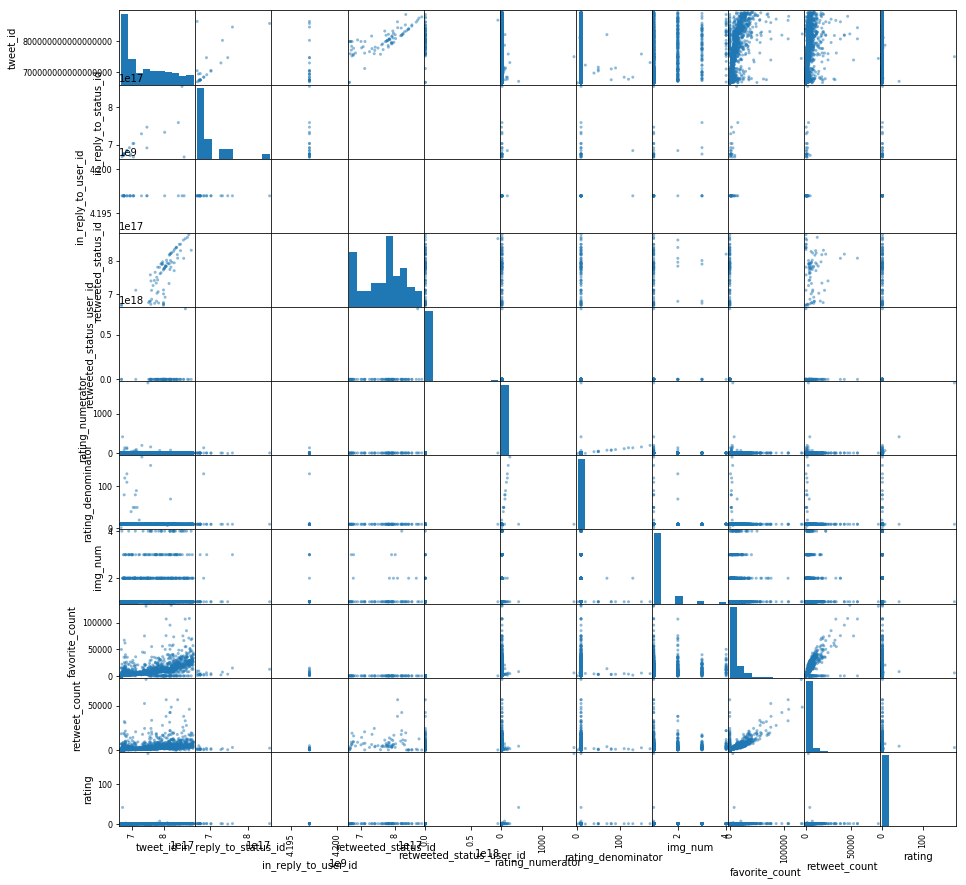

In [44]:
# use scatter matrix to identify possible correlations
pd.plotting.scatter_matrix(df, figsize = (15, 15));

A quasi-linear correlation between "favorite_count" and "retweet_count" might be possible and will be further assessed.

                            OLS Regression Results                            
Dep. Variable:          retweet_count   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     3449.
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:51:32   Log-Likelihood:                -19604.
No. Observations:                2073   AIC:                         3.921e+04
Df Residuals:                    2071   BIC:                         3.922e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        150.0920     83.316      1.

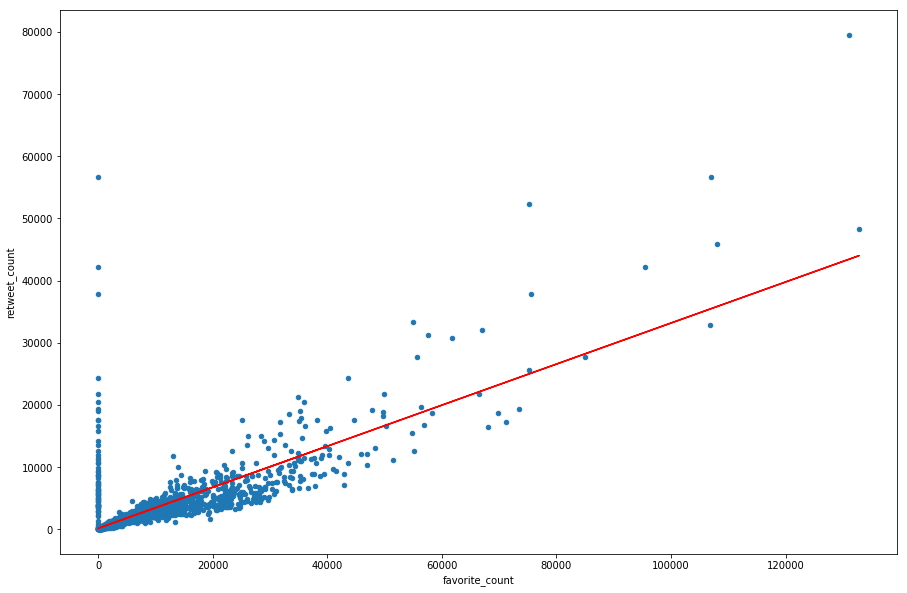

In [45]:
# plot correlation between "favorite_count" and "retweet_count"
df.plot(x='favorite_count', y='retweet_count', kind = 'scatter', figsize = (15, 10));
df['intercept'] = 1 
lm = sm.OLS(df['retweet_count'], df[['intercept', 'favorite_count']]) 
results = lm.fit() 
print(results.summary())
plt.plot(df.favorite_count.values, (results.params[0] + results.params[1] * df.favorite_count.values), color='red');

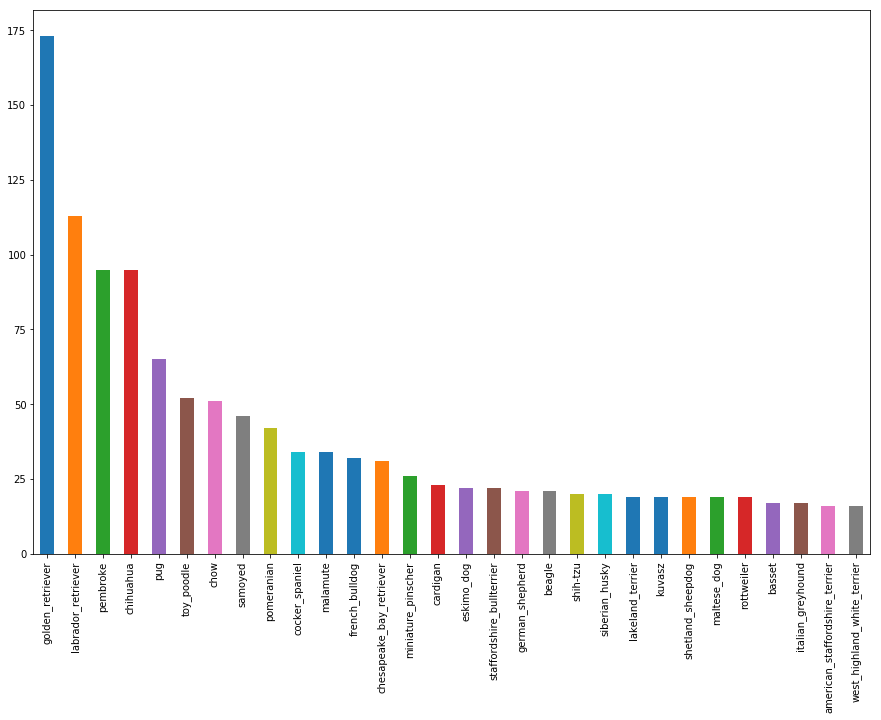

In [46]:
# show most favorite dog breeds
df.dog_breed[df.dog_breed != 'None'].value_counts()[:30].plot(kind = 'bar', figsize = (15, 10));

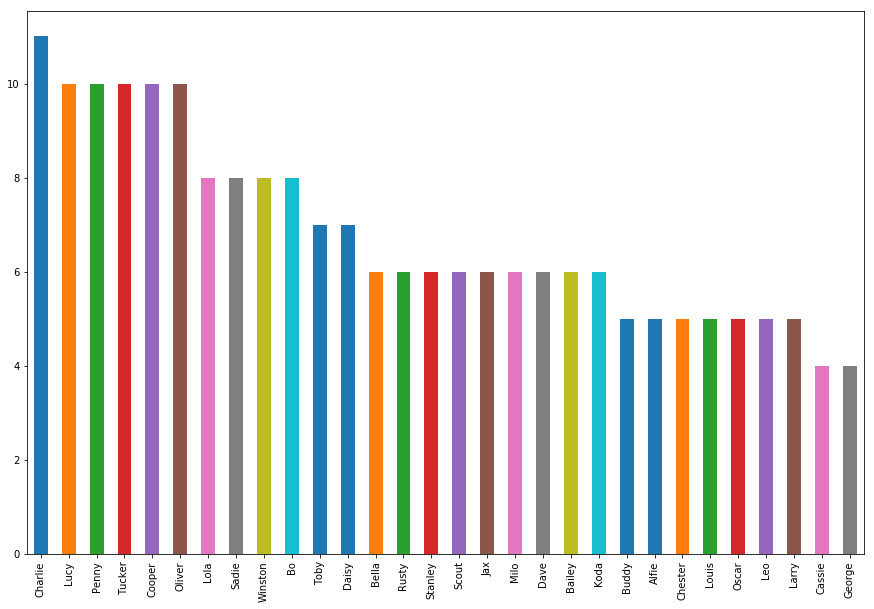

In [47]:
# show most favorite dog names
df.name[df.name != 'None'].value_counts()[:30].plot(kind = 'bar', figsize = (15, 10));

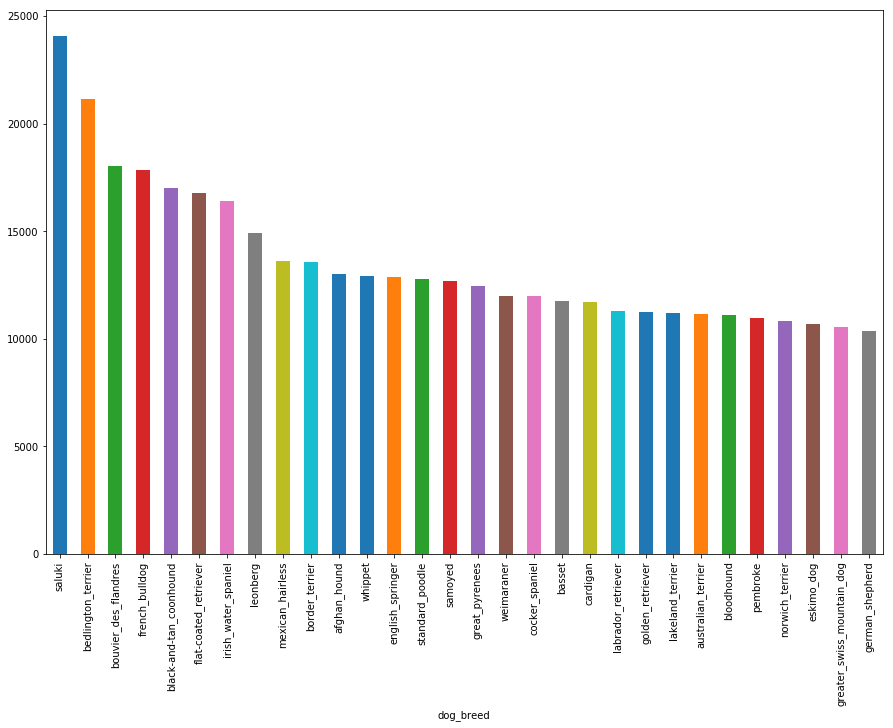

In [48]:
# show dog breeds with highest count of favorites
grouped = df.groupby(['dog_breed'])['favorite_count'].mean(); 
grouped.sort_values(ascending = False)[:30].plot(kind = 'bar', figsize = (15, 10));

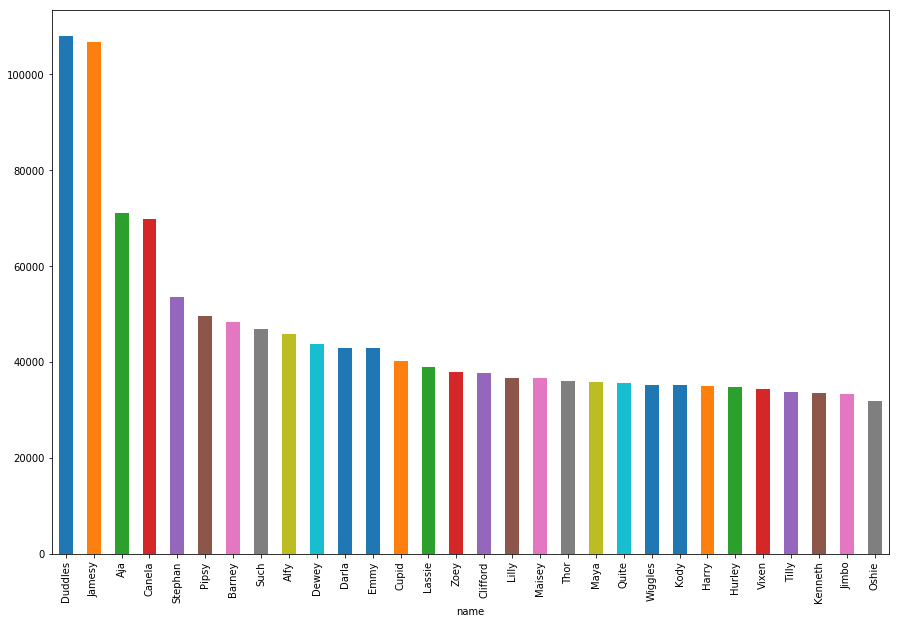

In [49]:
# show dog names with highest count of favorites
grouped = df.groupby(['name'])['favorite_count'].mean(); 
grouped.sort_values(ascending = False)[:30].plot(kind = 'bar', figsize = (15, 10));

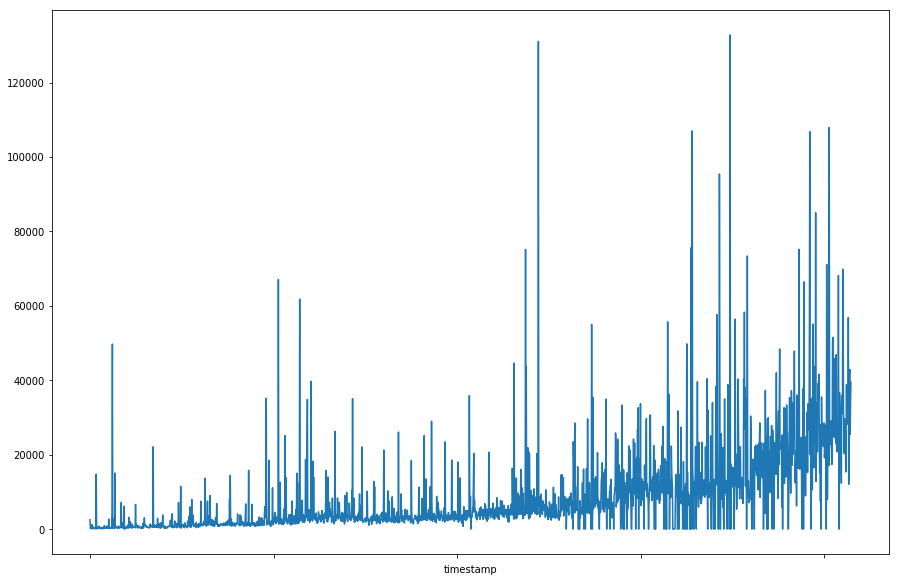

In [50]:
# show favorite_count vs time
grouped = df.groupby(['timestamp'])['favorite_count'].mean(); 
grouped.plot(kind = 'line', figsize = (15, 10));

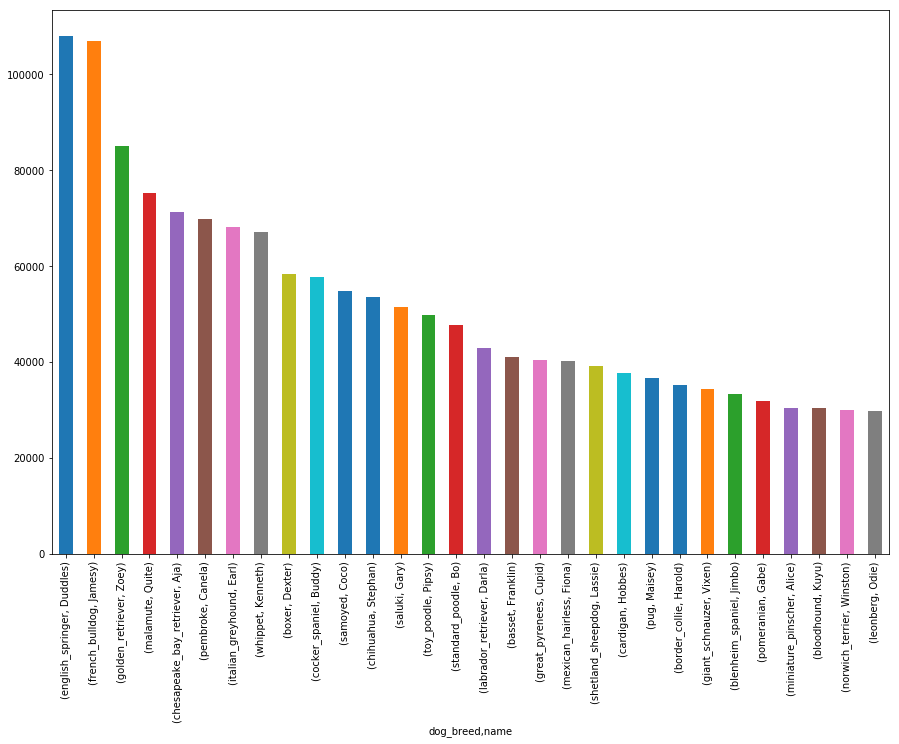

In [51]:
# show the name of the dog with highest count of favorites for each breed
grouped = df.groupby(['dog_breed', 'name'])['favorite_count'].mean();
mask = grouped.groupby('dog_breed').apply(lambda g: g == g[g.idxmax()]);
grouped[mask].sort_values(ascending = False)[:30].plot(kind = 'bar', figsize = (15, 10));

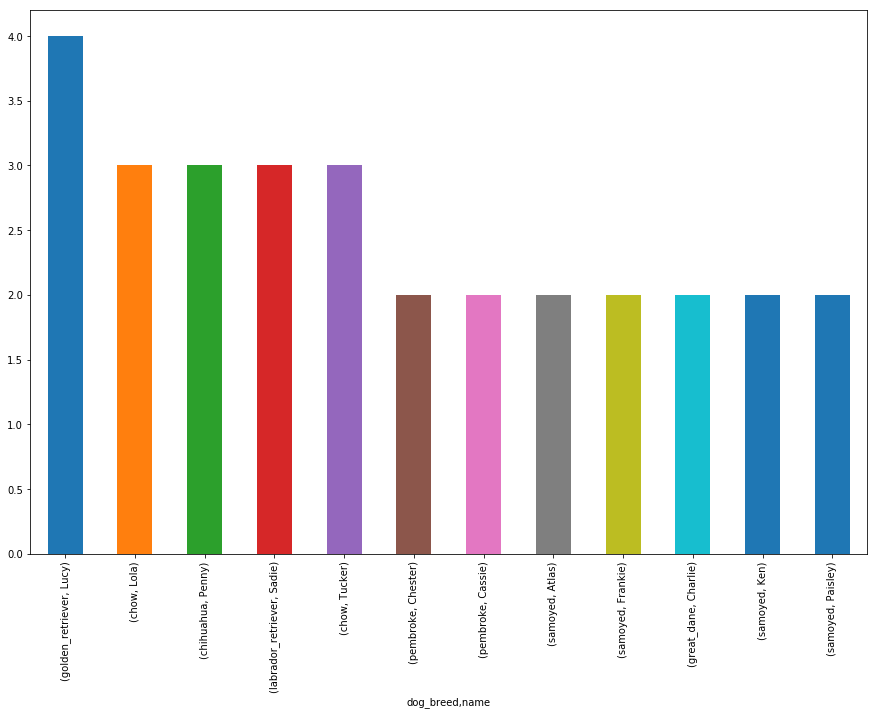

In [52]:
# which name is popular with a certain breed
df_copy = df.copy()
df_copy = df_copy[df_copy.name != 'None']
grouped = df_copy.groupby(['dog_breed', 'name'])['tweet_id'].count();
mask = grouped.groupby('dog_breed').apply(lambda g: g == g[g.idxmax()]);
grouped[mask].sort_values(ascending = False)[:12].plot(kind = 'bar', figsize = (15, 10));

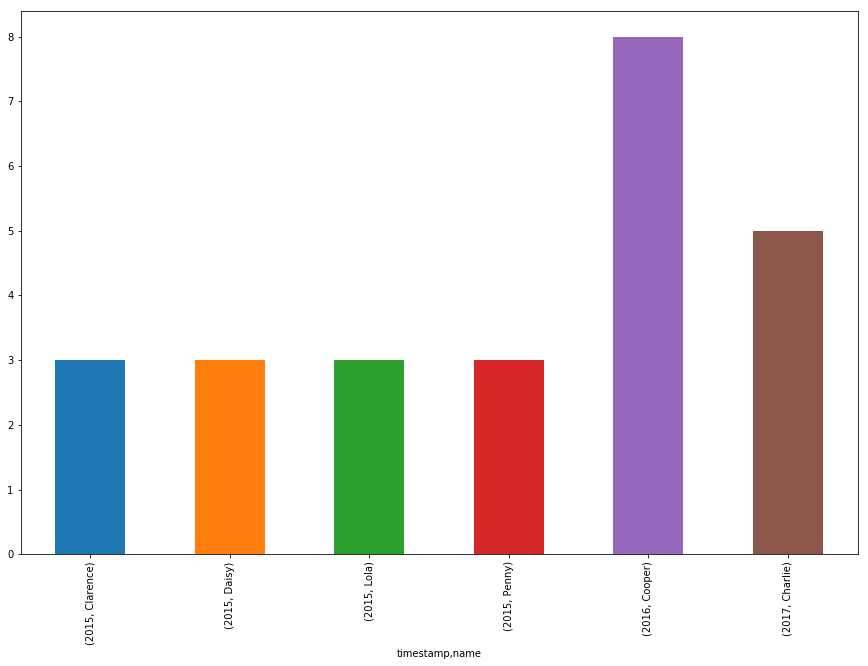

In [53]:
# which name was most frequently choosen for a dog in each year
df_copy = df.copy()
df_copy = df_copy[df_copy.name != 'None']
df_copy['timestamp'] = pd.DatetimeIndex(df_copy['timestamp']).year
grouped = df_copy.groupby(['timestamp', 'name'])['name'].count();
mask = grouped.groupby('timestamp').apply(lambda g: g == g[g.idxmax()]); 
grouped[mask].plot(kind = 'bar', figsize = (15, 10));

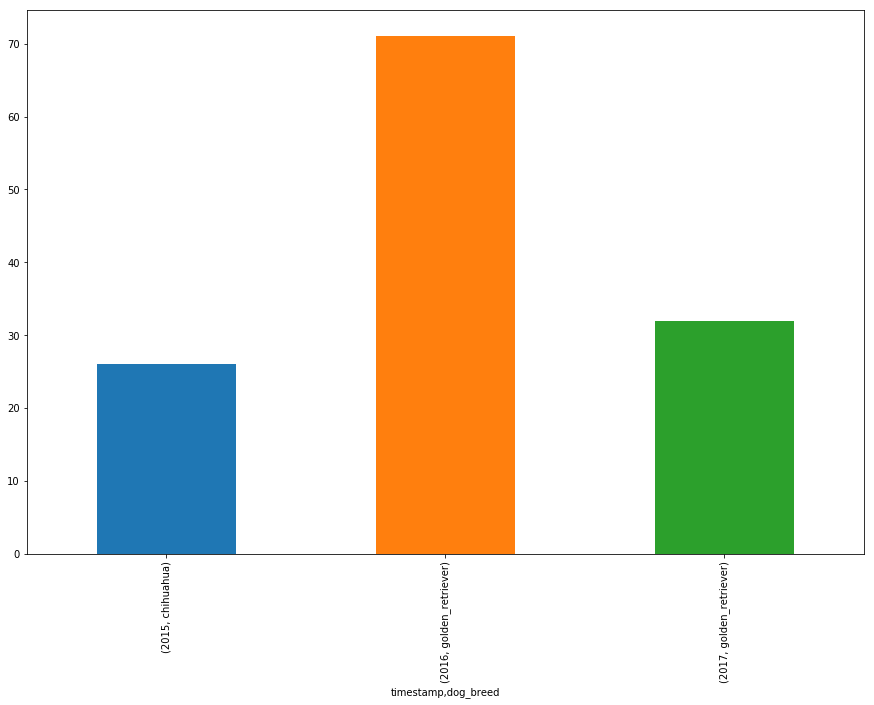

In [54]:
# which dog breed most frequently choosen for a dog in each year
grouped = df_copy.groupby(['timestamp', 'dog_breed'])['dog_breed'].count();
mask = grouped.groupby('timestamp').apply(lambda g: g == g[g.idxmax()]); 
grouped[mask].plot(kind = 'bar', figsize = (15, 10));